In [1]:
!pip install tensorflow
!pip install rarfile
!pip install scikeras
import os
import urllib.request
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, InputLayer
from keras import Input
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout

In [2]:
# Параметры загрузки и пути к файлам
DOWNLOAD_URL = "https://cloclo51.cloud.mail.ru/public/2xmaDK3pLewzE89PoMtR/g/no/xFQi/3VGxvfw2n"  # Ваш URL с архивом
ARCHIVE_PATH = os.path.join("datasets", "LR1_datasets.rar")
DATA_PATH = "datasets"  # Папка для распаковки

# Функция для скачивания архива
def fetch_dataset(download_url=DOWNLOAD_URL, archive_path=ARCHIVE_PATH, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    if not os.path.isfile(archive_path):
        urllib.request.urlretrieve(download_url, archive_path)

    # Распаковка архива через WinRAR
    if os.path.isfile(archive_path):
        subprocess.run(['C:\\Program Files\\WinRAR\\WinRAR.exe', 'x', archive_path, data_path], check=True)
    else:
        print(f"Файл архива {archive_path} не найден!")

# Функция для загрузки данных из файла V5.csv
def load_v5_data(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "V5.csv")
    if os.path.isfile(csv_path):
        return pd.read_csv(csv_path)
    else:
        print(f"Файл {csv_path} не найден!")
        return None

# Выполнение загрузки и чтение данных
fetch_dataset()
data = load_v5_data()

# Удаление столбца motor_UPDRS
data = data.drop(columns=['motor_UPDRS'])

In [3]:
# Выводим первые строки файла V5.csv
print(data.head())       # Вывод первых 5 строк
print(data.shape)        # Вывод размера набора данных
print(data.dtypes)       # Вывод типов данных
data.info()              # Этот метод сам выводит информацию
print(data.describe())   # Вывод статистической информации

   Unnamed: 0  index  subject#  age  sex  test_time  total_UPDRS  Jitter(%)  \
0           0      0         1   72    0     5.6431       34.398    0.00662   
1           1      1         1   72    0    12.6660       34.894    0.00300   
2           2      2         1   72    0    19.6810       35.389    0.00481   
3           3      3         1   72    0    25.6470       35.810    0.00528   
4           4      4         1   72    0    33.6420       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  ...  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0     0.000034     0.00401  ...        0.230       0.01438       0.01309   
1     0.000017     0.00132  ...        0.179       0.00994       0.01072   
2          NaN     0.00205  ...        0.181       0.00734       0.00844   
3          NaN     0.00191  ...        0.327       0.01106       0.01265   
4     0.000020     0.00093  ...        0.176       0.00679       0.00929   

   Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE      DFA   

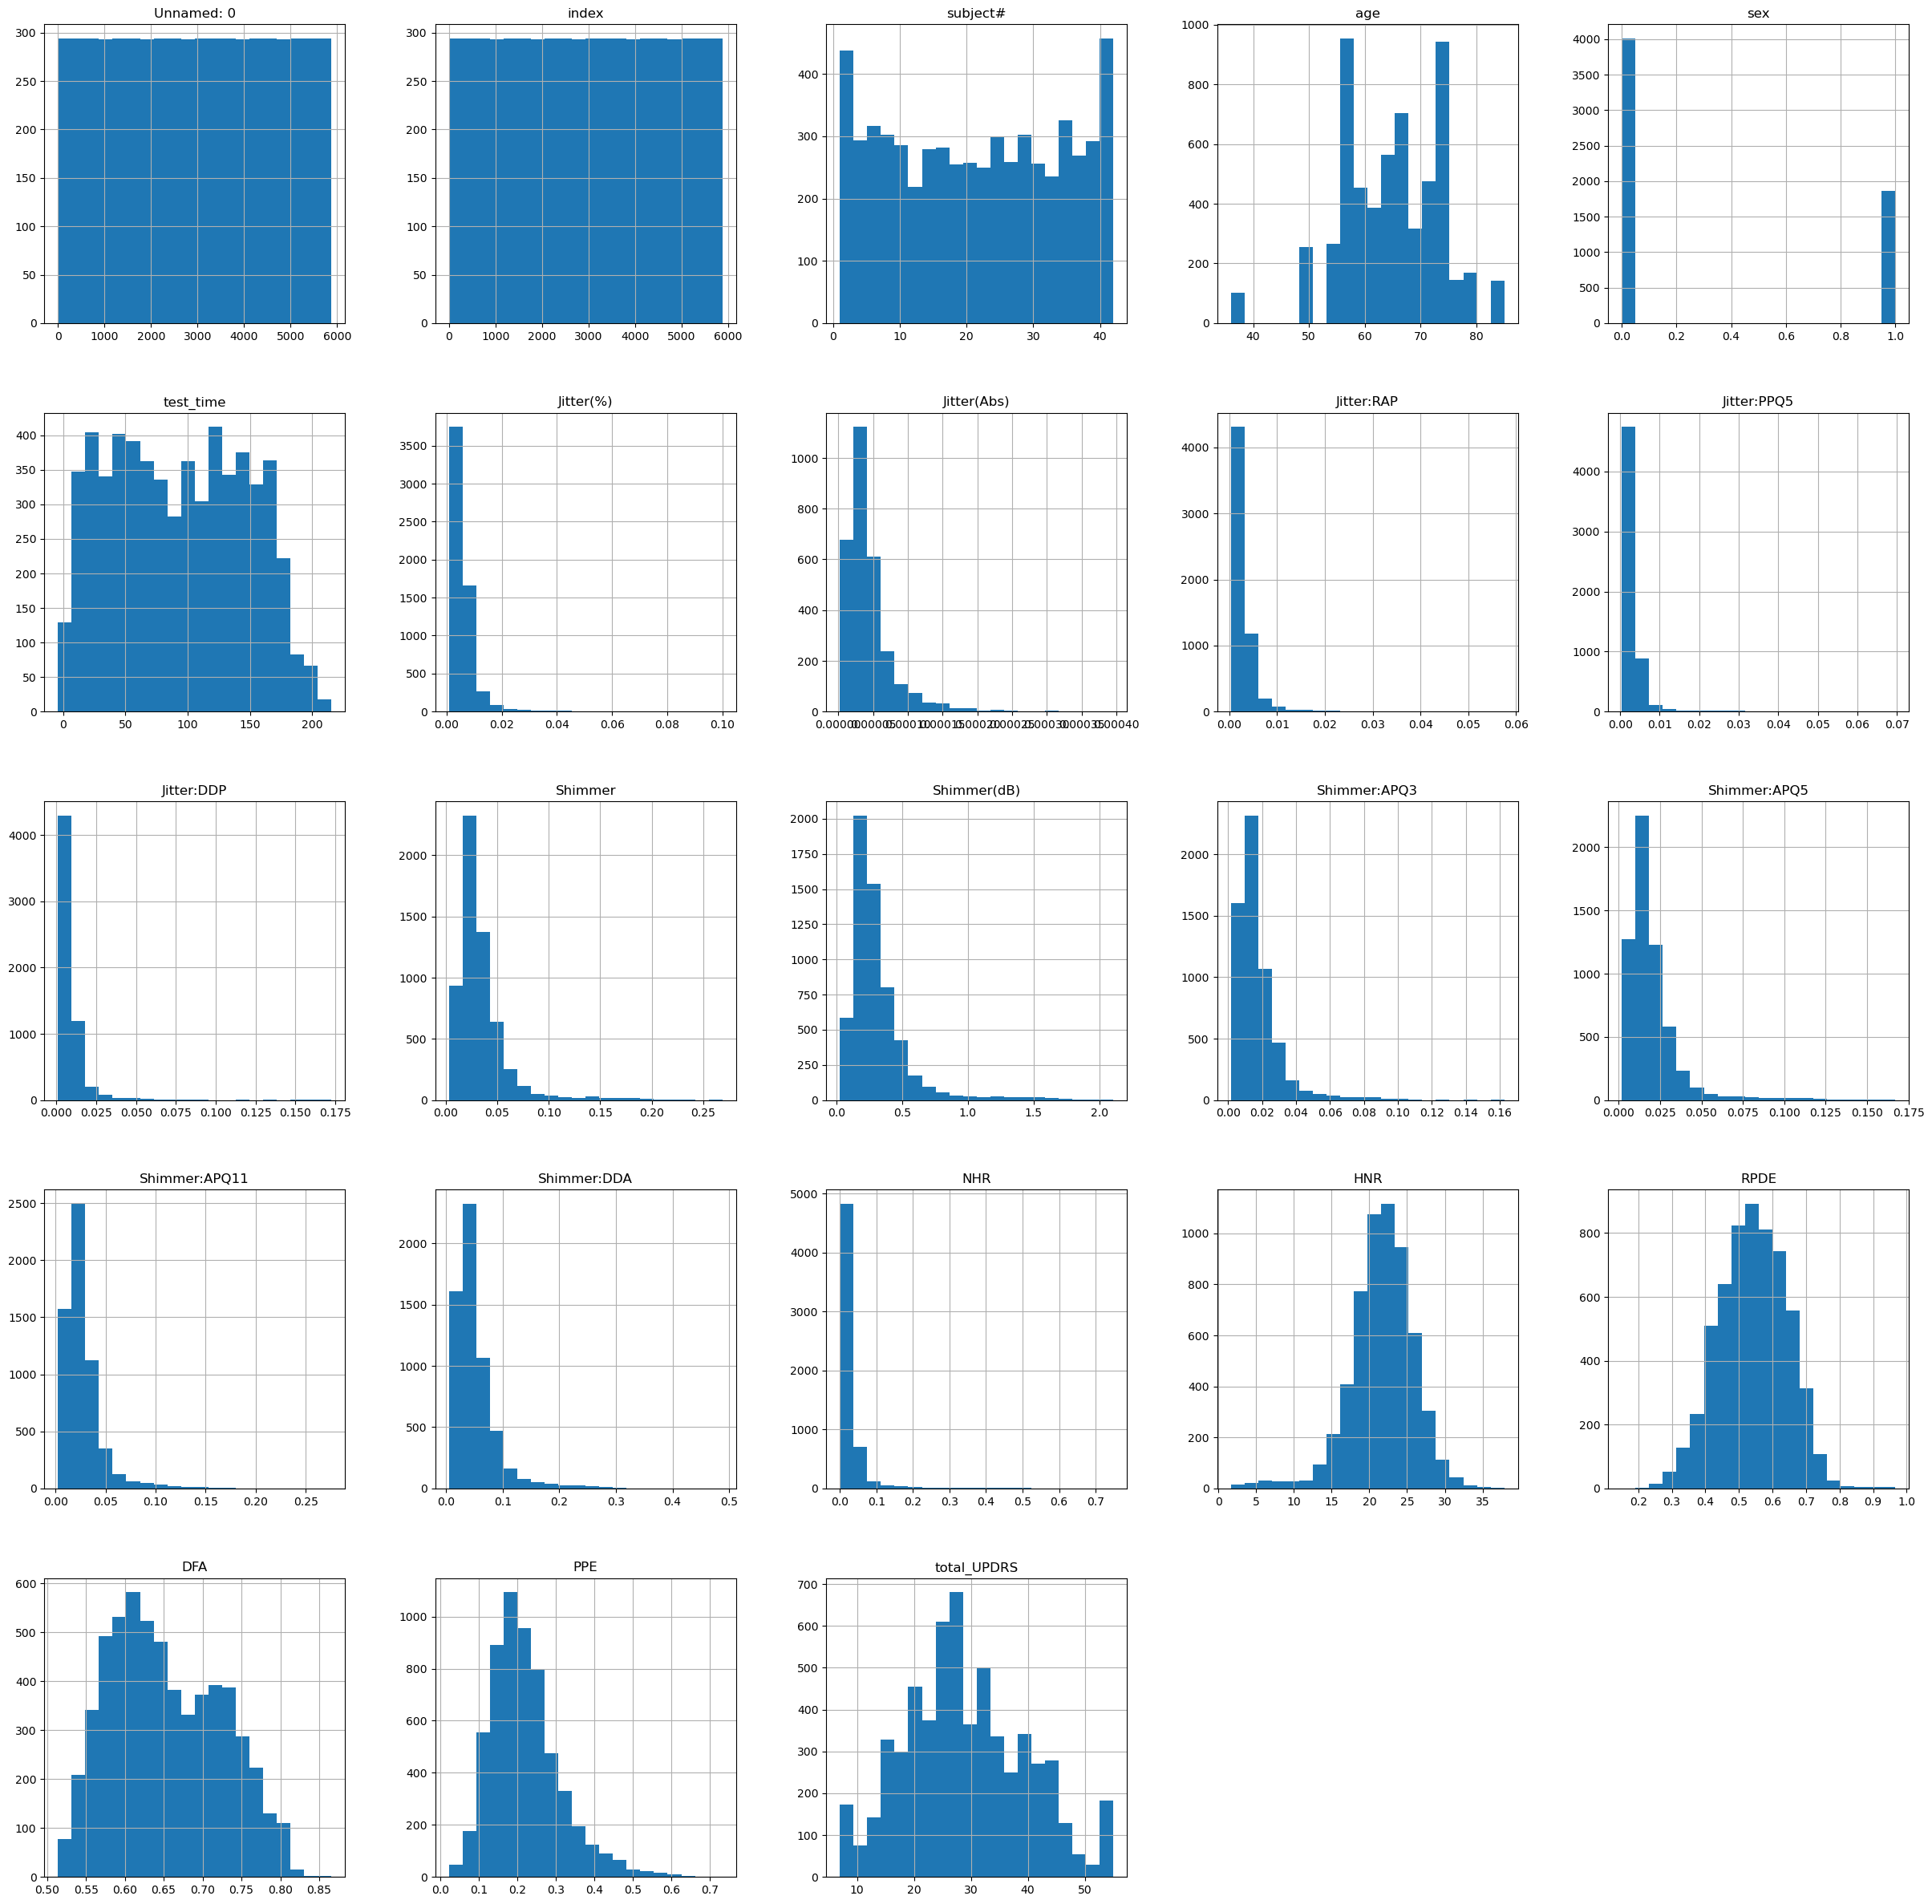

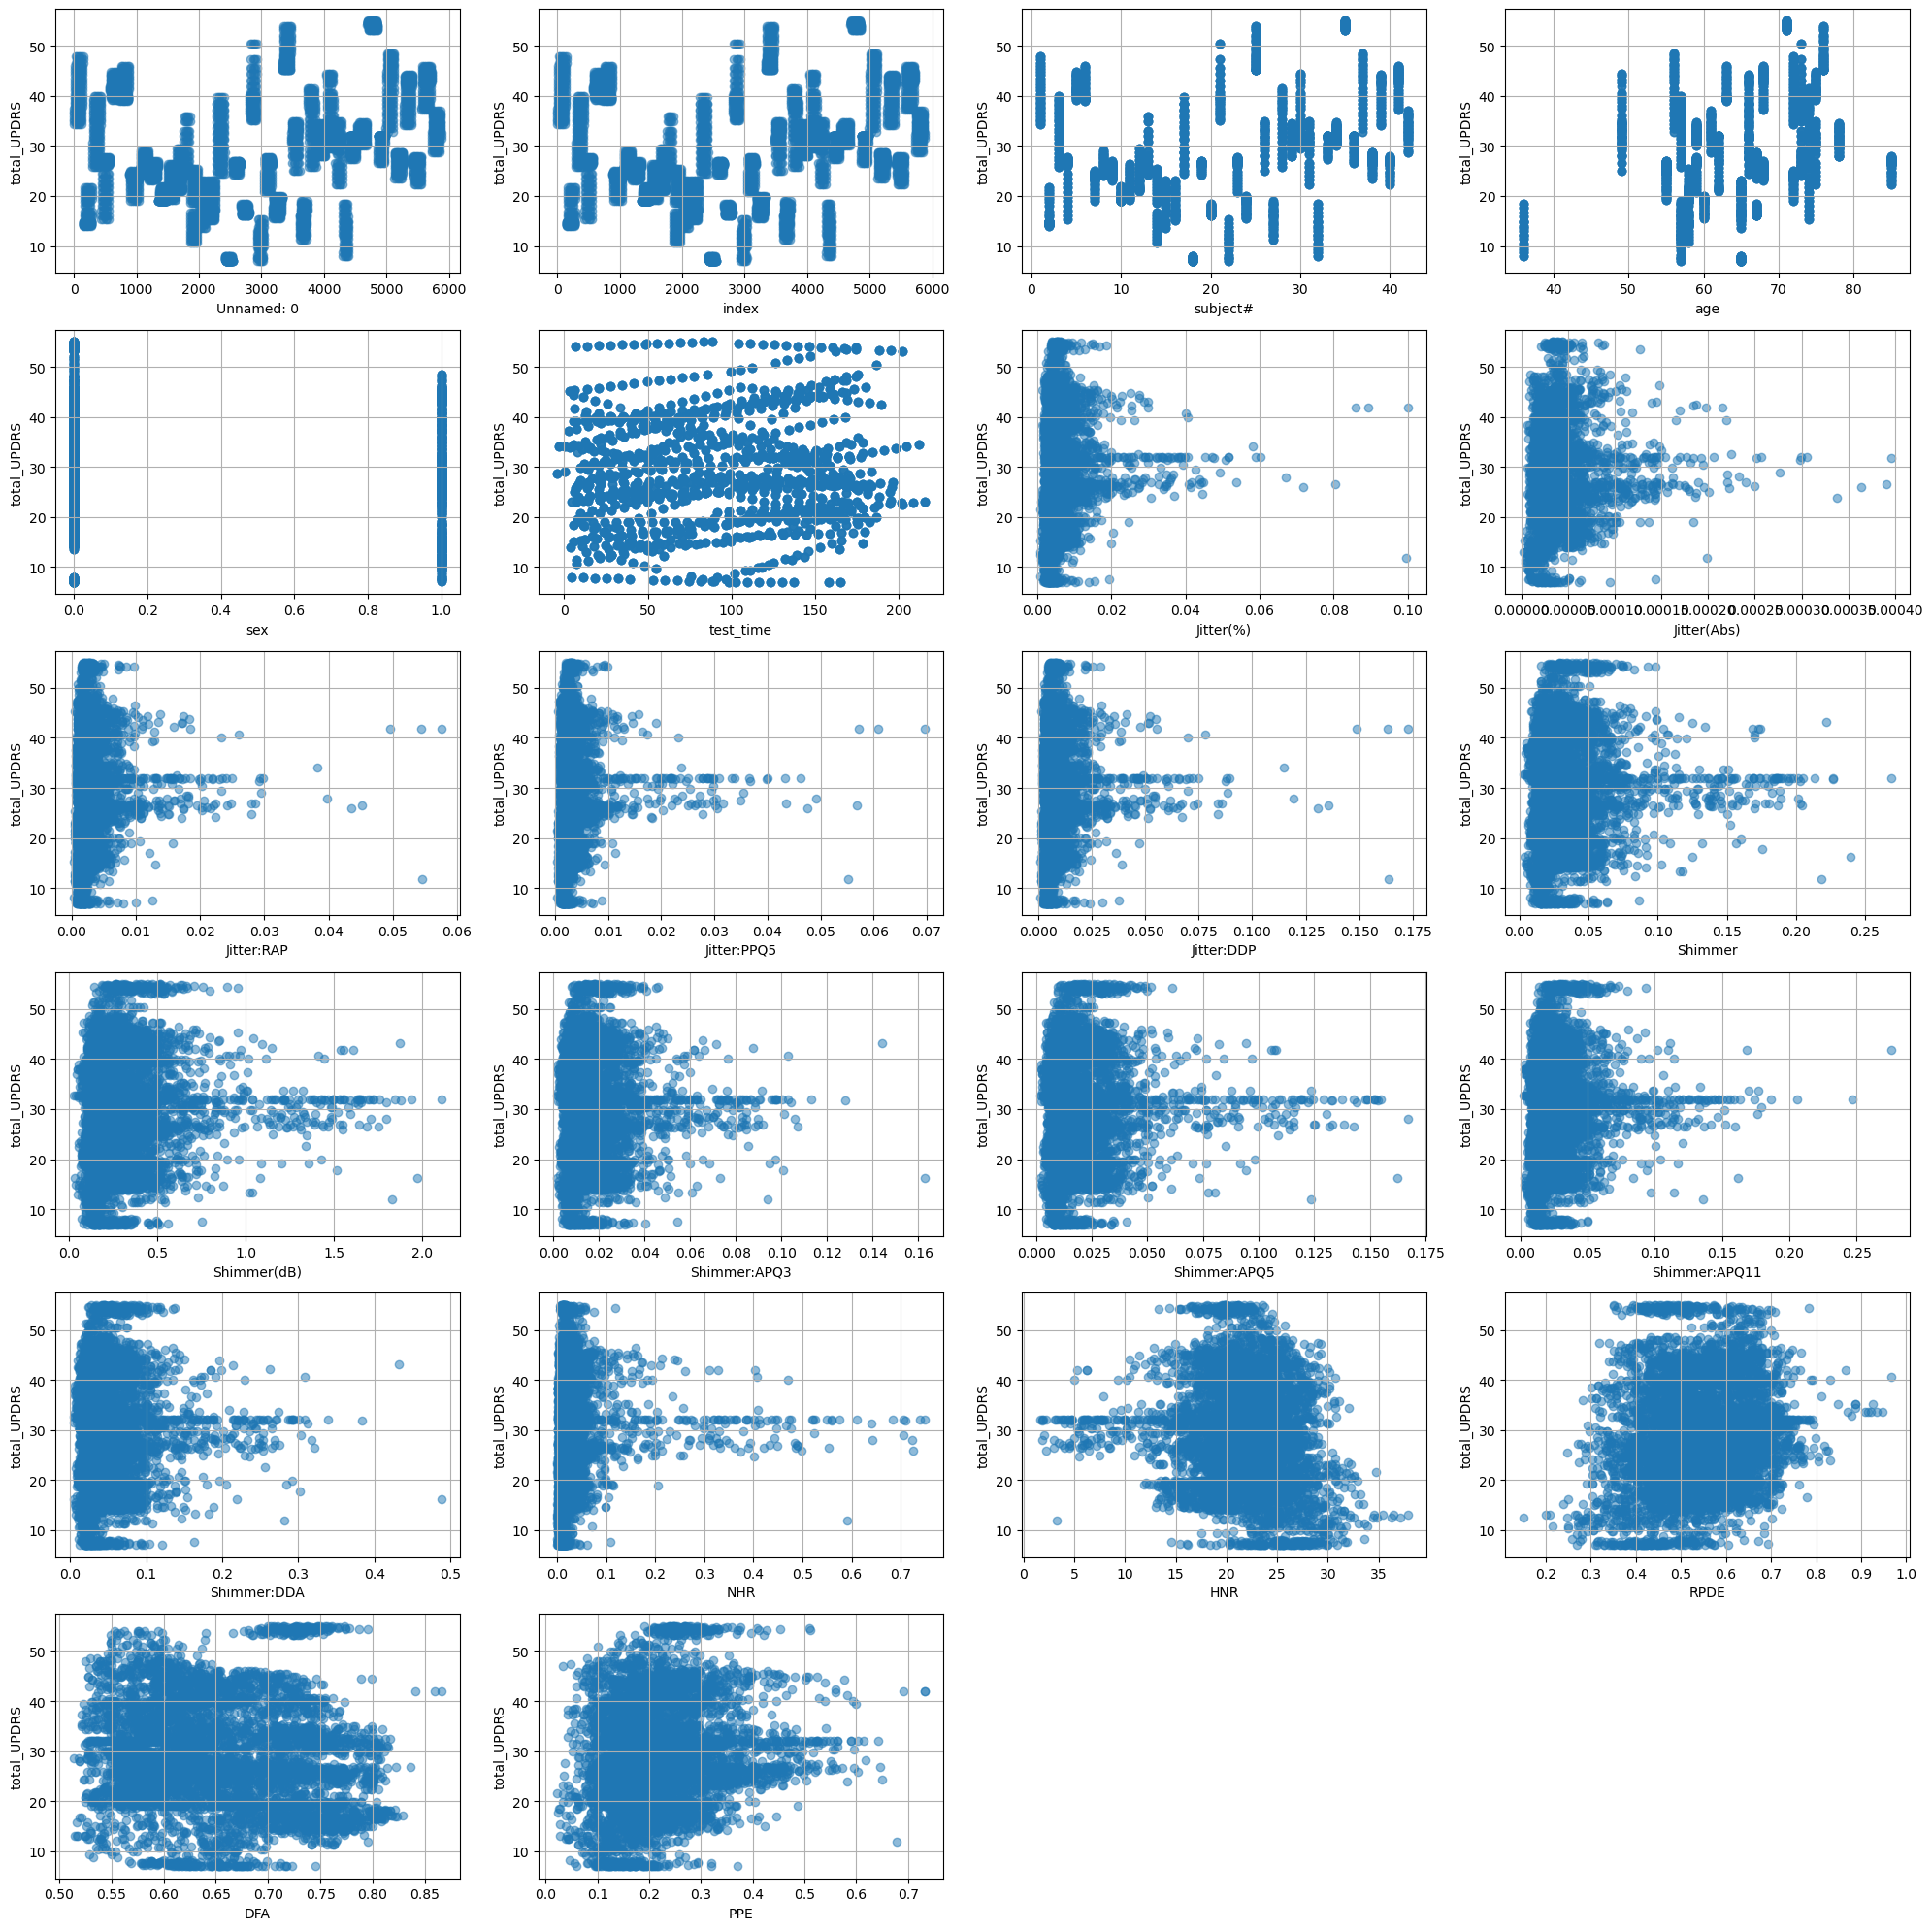

In [4]:
# Выбираем все столбцы для анализа
columns_to_plot = data.drop(columns=['total_UPDRS'])  # Удаляем 'total_UPDRS' из признаков для диаграмм рассеивания

# Создаем новый DataFrame с зависимостями
data_for_scatter = pd.concat([columns_to_plot, data['total_UPDRS']], axis=1)

# Гистограммы распределения признаков
data_for_scatter.hist(bins=20, figsize=(30,30))
plt.show()

# Количество признаков для отображения
num_columns = columns_to_plot.shape[1]

# Определяем количество строк и столбцов для отображения подграфиков
fig, axes = plt.subplots(nrows=(num_columns // 4) + 1, ncols=4, figsize=(20, 20))

# Плоский список осей для итерации
axes = axes.ravel()

# Создаем диаграммы рассеивания для каждого признака
for idx, column in enumerate(columns_to_plot.columns):
    axes[idx].scatter(data[column], data['total_UPDRS'], alpha=0.5)
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('total_UPDRS')
    axes[idx].grid(True)

# Убираем пустые графики, если есть
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Показываем все графики в одном окне
plt.tight_layout()
plt.show()


In [5]:
data = data.drop(['Unnamed: 0', 'index', 'subject#'], axis=1)
# Проверка на пропуски
print(data.isnull().sum())

age                 0
sex                 0
test_time           0
total_UPDRS         0
Jitter(%)           0
Jitter(Abs)      2931
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer             0
Shimmer(dB)         0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64


In [6]:
# Замена пропусков на среднее значение по каждому столбцу
data = data.fillna(data.mean())

In [7]:
# Проверка, что пропуски были успешно заменены
print(data.isnull().sum())

age              0
sex              0
test_time        0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64


In [8]:
corr_matrix = data.corr()
print(corr_matrix['total_UPDRS'].sort_values(ascending=False))


total_UPDRS      1.000000
age              0.310290
RPDE             0.156897
PPE              0.156195
Shimmer:APQ11    0.120838
Shimmer(dB)      0.098790
Shimmer          0.092141
Shimmer:APQ5     0.083467
Shimmer:DDA      0.079363
Shimmer:APQ3     0.079363
test_time        0.075263
Jitter(%)        0.074247
Jitter:DDP       0.064027
Jitter:RAP       0.064015
Jitter:PPQ5      0.063352
NHR              0.060952
Jitter(Abs)      0.037774
sex             -0.096559
DFA             -0.113475
HNR             -0.162117
Name: total_UPDRS, dtype: float64


In [9]:
# Подготовка данных: исключаем ненужные столбцы
X = data.drop(['total_UPDRS'], axis=1)
y = data['total_UPDRS']  # Целевой признак

# Отбор признаков с помощью SelectKBest
best_features = SelectKBest(score_func=f_regression, k=5)
fit = best_features.fit(X, y)

# Сохраняем результаты
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X.columns)

# Объединяем названия признаков и их важность в один DataFrame
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature', 'Score']  # Переименовываем столбцы

# Выводим таблицу с оценкой важности признаков
print(feature_scores.sort_values(by='Score', ascending=False))

          Feature       Score
0             age  625.693134
15            HNR  158.519590
16           RPDE  148.221481
18            PPE  146.865694
12  Shimmer:APQ11   87.026534
17            DFA   76.610378
9     Shimmer(dB)   57.881913
1             sex   55.272949
8         Shimmer   50.288410
11   Shimmer:APQ5   41.202964
13    Shimmer:DDA   37.225700
10   Shimmer:APQ3   37.225205
2       test_time   33.456937
3       Jitter(%)   32.554771
7      Jitter:DDP   24.175561
5      Jitter:RAP   24.166432
6     Jitter:PPQ5   23.665959
14            NHR   21.900161
4     Jitter(Abs)    8.392179


In [10]:
new_data = data.drop([ 'Jitter(Abs)', 'NHR', 'Jitter:PPQ5', 
           'Jitter:RAP', 'Jitter:DDP', 'Jitter(%)', 'test_time', 'Shimmer:APQ3', 
           'Shimmer:DDA'], axis=1)

scaler = StandardScaler()
new_scaler = StandardScaler()
data_standart = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
new_data_standart = pd.DataFrame(new_scaler.fit_transform(new_data), columns=new_data.columns)


In [11]:
# Определяем целевой признак и признаки
X = data.drop('total_UPDRS', axis=1)
y = data['total_UPDRS']

# Для стандартизованных данных
X_standart = data_standart.drop('total_UPDRS', axis=1)
y_standart = data_standart['total_UPDRS']

# Повторяем то же для new_data и new_data_standart
X_new = new_data.drop('total_UPDRS', axis=1)
y_new = new_data['total_UPDRS']

# Разделение для обычных данных
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Разделение для стандартизированных данных
X_train_stand, X_temp_stand, y_train_stand, y_temp_stand = train_test_split(X_standart, y_standart, test_size=0.4, random_state=42)
X_val_stand, X_test_stand, y_val_stand, y_test_stand = train_test_split(X_temp_stand, y_temp_stand, test_size=0.5, random_state=42)

X_train_new, X_temp_new, y_train_new, y_temp_new = train_test_split(X_new, y_new, test_size=0.4, random_state=42)
X_val_new, X_test_new, y_val_new, y_test_new = train_test_split(X_temp_new, y_temp_new, test_size=0.5, random_state=42)

X_train_new_stand, X_temp_new_stand, y_train_new_stand, y_temp_new_stand = train_test_split(new_data_standart.drop('total_UPDRS', axis=1), new_data_standart['total_UPDRS'], test_size=0.4, random_state=42)
X_val_new_stand, X_test_new_stand, y_val_new_stand, y_test_new_stand = train_test_split(X_temp_new_stand, y_temp_new_stand, test_size=0.5, random_state=42)


In [12]:
def create_dense_model(input_shape):
    model = Sequential()
    model.add(tf.keras.layers.Input(shape=(input_shape,)))  # Используем Input
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Для регрессии
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])
    return model

# Функция для создания LSTM модели
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(InputLayer(shape=(input_shape, 1)))  # Явное определение входного слоя
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Для регрессии
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [13]:
# Полносвязная модель на обычных данных
model_dense = create_dense_model(X_train.shape[1])
history_dense = model_dense.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Полносвязная модель на стандартизированных данных
model_dense_stand = create_dense_model(X_train_stand.shape[1])
history_dense_stand = model_dense_stand.fit(X_train_stand, y_train_stand, epochs=100, batch_size=32, validation_data=(X_val_stand, y_val_stand), verbose=1)

# Полносвязная модель на new_data
model_dense_new = create_dense_model(X_train_new.shape[1])
history_dense_new = model_dense_new.fit(X_train_new, y_train_new, epochs=100, batch_size=32, validation_data=(X_val_new, y_val_new), verbose=1)

# Полносвязная модель на new_data_standart
model_dense_new_stand = create_dense_model(X_train_new_stand.shape[1])
history_dense_new_stand = model_dense_new_stand.fit(X_train_new_stand, y_train_new_stand, epochs=100, batch_size=32, validation_data=(X_val_new_stand, y_val_new_stand), verbose=1)


Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 364.4979 - mean_squared_error: 364.4979 - root_mean_squared_error: 18.5351 - val_loss: 100.2400 - val_mean_squared_error: 100.2400 - val_root_mean_squared_error: 10.0120
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110.5789 - mean_squared_error: 110.5789 - root_mean_squared_error: 10.5141 - val_loss: 94.0469 - val_mean_squared_error: 94.0469 - val_root_mean_squared_error: 9.6978
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.2359 - mean_squared_error: 109.2359 - root_mean_squared_error: 10.4509 - val_loss: 94.9077 - val_mean_squared_error: 94.9077 - val_root_mean_squared_error: 9.7421
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.3074 - mean_squared_error: 104.3074 - root_mean_squared_error: 10.2104 - val_loss: 94.1116 - val_mean_squared_error: 94.1116 - val_root_mean_squared_error: 9.7011
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106.7318 - mean_squared_

In [14]:
# LSTM модель на обычных данных
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_lstm = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))

model_lstm = create_lstm_model(X_train_lstm.shape[1])
history_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(X_val_lstm, y_val), verbose=1)

# LSTM модель на стандартизированных данных
X_train_stand_lstm = X_train_stand.values.reshape((X_train_stand.shape[0], X_train_stand.shape[1], 1))
X_val_stand_lstm = X_val_stand.values.reshape((X_val_stand.shape[0], X_val_stand.shape[1], 1))

model_lstm_stand = create_lstm_model(X_train_stand_lstm.shape[1])
history_lstm_stand = model_lstm_stand.fit(X_train_stand_lstm, y_train_stand, epochs=100, batch_size=32, validation_data=(X_val_stand_lstm, y_val_stand), verbose=1)

# LSTM модель на new_data
X_train_new_lstm = X_train_new.values.reshape((X_train_new.shape[0], X_train_new.shape[1], 1))
X_val_new_lstm = X_val_new.values.reshape((X_val_new.shape[0], X_val_new.shape[1], 1))

model_lstm_new = create_lstm_model(X_train_new_lstm.shape[1])
history_lstm_new = model_lstm_new.fit(X_train_new_lstm, y_train_new, epochs=100, batch_size=32, validation_data=(X_val_new_lstm, y_val_new), verbose=1)

# LSTM модель на new_data_standart
X_train_new_stand_lstm = X_train_new_stand.values.reshape((X_train_new_stand.shape[0], X_train_new_stand.shape[1], 1))
X_val_new_stand_lstm = X_val_new_stand.values.reshape((X_val_new_stand.shape[0], X_val_new_stand.shape[1], 1))

model_lstm_new_stand = create_lstm_model(X_train_new_stand_lstm.shape[1])
history_lstm_new_stand = model_lstm_new_stand.fit(X_train_new_stand_lstm, y_train_new_stand, epochs=100, batch_size=32, validation_data=(X_val_new_stand_lstm, y_val_new_stand), verbose=1)


Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 616.1777 - root_mean_squared_error: 24.3674 - val_loss: 105.0682 - val_root_mean_squared_error: 10.2503
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 123.8561 - root_mean_squared_error: 11.1274 - val_loss: 101.9767 - val_root_mean_squared_error: 10.0984
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 121.1841 - root_mean_squared_error: 11.0072 - val_loss: 99.3582 - val_root_mean_squared_error: 9.9679
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 116.4134 - root_mean_squared_error: 10.7890 - val_loss: 97.3690 - val_root_mean_squared_error: 9.8676
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 114.1888 - root_mean_squared_error: 10.6849 - val_loss: 95.9378 - val_root_mean_squared_error: 9.7948
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 109.1680 - root_mean_squared_error: 10.4467 - val_loss: 96.1846 - val_root_mean_squared_error: 9.8074
Epoch 7/100
111/1

In [15]:
# Оценка моделей с помощью RMSE и R²
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

# Полносвязная модель (обычные данные)
rmse_dense, r2_dense = evaluate_model(model_dense, X_test, y_test)

# Полносвязная модель (стандартизированные данные)
rmse_dense_stand, r2_dense_stand = evaluate_model(model_dense_stand, X_test_stand, y_test_stand)

# Полносвязная модель (new_data)
rmse_dense_new, r2_dense_new = evaluate_model(model_dense_new, X_test_new, y_test_new)

# Полносвязная модель (new_data_standart)
rmse_dense_new_stand, r2_dense_new_stand = evaluate_model(model_dense_new_stand, X_test_new_stand, y_test_new_stand)

# LSTM модель (обычные данные)
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
rmse_lstm, r2_lstm = evaluate_model(model_lstm, X_test_lstm, y_test)

# LSTM модель (стандартизированные данные)
X_test_stand_lstm = X_test_stand.values.reshape((X_test_stand.shape[0], X_test_stand.shape[1], 1))
rmse_lstm_stand, r2_lstm_stand = evaluate_model(model_lstm_stand, X_test_stand_lstm, y_test_stand)

# LSTM модель (new_data)
X_test_new_lstm = X_test_new.values.reshape((X_test_new.shape[0], X_test_new.shape[1], 1))
rmse_lstm_new, r2_lstm_new = evaluate_model(model_lstm_new, X_test_new_lstm, y_test_new)

# LSTM модель (new_data_standart)
X_test_new_stand_lstm = X_test_new_stand.values.reshape((X_test_new_stand.shape[0], X_test_new_stand.shape[1], 1))
rmse_lstm_new_stand, r2_lstm_new_stand = evaluate_model(model_lstm_new_stand, X_test_new_stand_lstm, y_test_new_stand)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [16]:
# Вывод результатов
print(f"Полносвязная Dense модель (обычные данные): RMSE = {rmse_dense}, R² = {r2_dense}")
print(f"Полносвязная Dense модель (стандартизированные данные): RMSE = {rmse_dense_stand}, R² = {r2_dense_stand}")
print(f"Полносвязная Dense модель (new_data): RMSE = {rmse_dense_new}, R² = {r2_dense_new}")
print(f"Полносвязная Dense модель (new_data_standart): RMSE = {rmse_dense_new_stand}, R² = {r2_dense_new_stand}")

print(f"LSTM модель (обычные данные): RMSE = {rmse_lstm}, R² = {r2_lstm}")
print(f"LSTM модель (стандартизированные данные): RMSE = {rmse_lstm_stand}, R² = {r2_lstm_stand}")
print(f"LSTM модель (new_data): RMSE = {rmse_lstm_new}, R² = {r2_lstm_new}")
print(f"LSTM модель (new_data_standart): RMSE = {rmse_lstm_new_stand}, R² = {r2_lstm_new_stand}")

Полносвязная Dense модель (обычные данные): RMSE = 9.75507773680993, R² = 0.1772291090419531
Полносвязная Dense модель (стандартизированные данные): RMSE = 0.528482916045758, R² = 0.7235631253584587
Полносвязная Dense модель (new_data): RMSE = 9.354925566621583, R² = 0.2433446244473697
Полносвязная Dense модель (new_data_standart): RMSE = 0.5415574575797677, R² = 0.709715965618297
LSTM модель (обычные данные): RMSE = 8.95114225399778, R² = 0.3072534567916584
LSTM модель (стандартизированные данные): RMSE = 0.5414618826303618, R² = 0.7098184161833043
LSTM модель (new_data): RMSE = 8.930432238470242, R² = 0.31045532631134676
LSTM модель (new_data_standart): RMSE = 0.3752801795958059, R² = 0.860605600782405


In [17]:
# Прогноз на тестовом наборе данных
X_test_new_stand_lstm = X_test_new_stand.values.reshape((X_test_new_stand.shape[0], X_test_new_stand.shape[1], 1))
y_pred_test_lstm_new_stand = model_lstm_new_stand.predict(X_test_new_stand_lstm)

# Оценка качества на тестовых данных
rmse_test_lstm_new_stand = np.sqrt(mean_squared_error(y_test_new_stand, y_pred_test_lstm_new_stand))
r2_test_lstm_new_stand = r2_score(y_test_new_stand, y_pred_test_lstm_new_stand)

print(f"Оценка на тестовом наборе: RMSE = {rmse_test_lstm_new_stand}, R² = {r2_test_lstm_new_stand}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Оценка на тестовом наборе: RMSE = 0.3752801795958059, R² = 0.860605600782405


Пробуем batch_size = 16, epochs = 50, dropout = 0.2
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE = 0.43035041918796124, R² = 0.816693219600175
Пробуем batch_size = 16, epochs = 50, dropout = 0.3
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE = 0.4152066231598265, R² = 0.8293671620672032
Пробуем batch_size = 16, epochs = 50, dropout = 0.4
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
RMSE = 0.45783765463631654, R² = 0.7925291505125942
Пробуем batch_size = 16, epochs = 100, dropout = 0.2
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
RMSE = 0.36735657615670586, R² = 0.8664297600259261
Пробуем batch_size = 16, epochs = 100, dropout = 0.3
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
RMSE = 0.38692491533502277, R² = 0.8518207264433282
Пробуем batch_size = 16, epochs = 100, dropout = 0.4
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE = 0.37054849517872973, R² = 0.8640985230177451
Пробуем batch_size = 16, epochs = 150, dropout = 0.2
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
RMSE = 0.35275939716074206, R² = 0.8768338

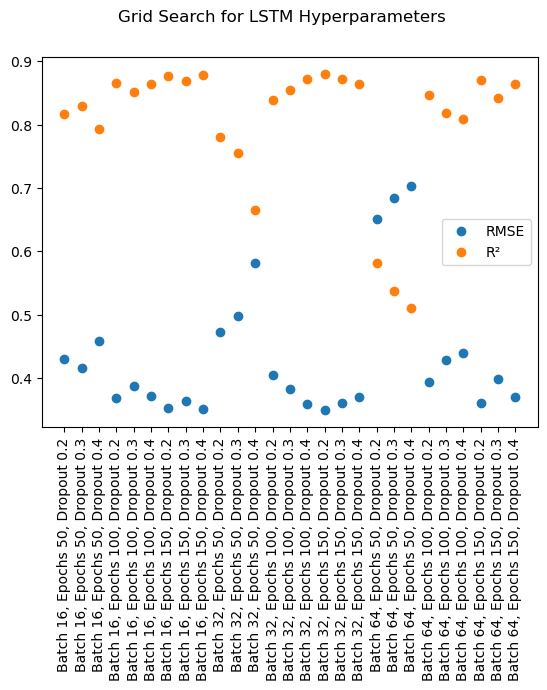

In [18]:
# Гиперпараметры для поиска
batch_sizes = [16, 32, 64]
epochs = [50, 100, 150]
dropouts = [0.2, 0.3, 0.4]

results_rmse = []
results_r2 = []
names = []

for batch_size in batch_sizes:
    for epoch in epochs:
        for dropout in dropouts:
            print(f"Пробуем batch_size = {batch_size}, epochs = {epoch}, dropout = {dropout}")
            
            # Создаем модель с текущими гиперпараметрами
            model = Sequential()
            model.add(Input(shape=(X_train_new_stand_lstm.shape[1], 1)))  # Указываем входной слой с shape
            model.add(Bidirectional(LSTM(64, return_sequences=False)))
            model.add(Dropout(dropout))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(1))  # Для регрессии
            
            # Компиляция модели
            model.compile(optimizer='adam', loss='mean_squared_error')
             
            # Обучение модели
            history = model.fit(X_train_new_stand_lstm, y_train_new_stand, epochs=epoch, batch_size=batch_size, validation_data=(X_val_new_stand_lstm, y_val_new_stand), verbose=0)
            
            # Оценка модели на тестовом наборе
            y_pred = model.predict(X_test_new_stand_lstm)
            rmse = np.sqrt(mean_squared_error(y_test_new_stand, y_pred))
            r2 = r2_score(y_test_new_stand, y_pred)
            
            # Сохранение результатов
            results_rmse.append(rmse)
            results_r2.append(r2)
            names.append(f"Batch {batch_size}, Epochs {epoch}, Dropout {dropout}")
            
            print(f"RMSE = {rmse}, R² = {r2}")

# Вывод результатов
print(f"Лучший RMSE: {min(results_rmse)}, лучший R²: {max(results_r2)}")
print(f"Параметры для лучшего результата: {names[results_rmse.index(min(results_rmse))]}")

# Визуализация
plt.plot(names, results_rmse, 'o', label='RMSE')
plt.plot(names, results_r2, 'o', label='R²')
plt.xticks(rotation=90)
plt.legend()
plt.suptitle('Grid Search for LSTM Hyperparameters')
plt.show()


In [41]:
# Обучение модели с лучшими гиперпараметрами
best_model_lstm = Sequential()
best_model_lstm.add(Input(shape=(X_train_new_stand_lstm.shape[1], 1)))  # Входной слой
best_model_lstm.add(Bidirectional(LSTM(64, return_sequences=False)))  # BiLSTM слой
best_model_lstm.add(Dropout(0.2))  # Используем dropout, найденный в процессе поиска
best_model_lstm.add(Dense(32, activation='relu'))  # Полносвязный слой
best_model_lstm.add(Dense(1))  # Выходной слой для регрессии

best_model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель с лучшими гиперпараметрами
history_best_lstm = best_model_lstm.fit(
    X_train_new_stand_lstm, y_train_new_stand,
    epochs=150,  # Значение epoch, которое будет найдено
    batch_size=32,  # Значение batch_size, которое будет найдено
    validation_data=(X_val_new_stand_lstm, y_val_new_stand),
    verbose=0
)

# Оценка на тестовой выборке после подбора гиперпараметров
y_pred_test_best_lstm_stand = best_model_lstm.predict(X_test_new_stand_lstm)

# Оценка качества модели после подбора гиперпараметров
rmse_test_best_lstm_stand = np.sqrt(mean_squared_error(y_test_new_stand, y_pred_test_best_lstm_stand))
r2_test_best_lstm_stand = r2_score(y_test_new_stand, y_pred_test_best_lstm_stand)

print(f"Лучший LSTM после Grid поиска (тестовые стандартизированные данные): RMSE = {rmse_test_best_lstm_stand}, R² = {r2_test_best_lstm_stand}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Лучший LSTM после Grid поиска (тестовые стандартизированные данные): RMSE = 0.3662525467209726, R² = 0.8672314001471334


In [42]:
print(f"До поиска гиперпараметров: RMSE = {rmse_test_lstm_new_stand}, R² = {r2_test_lstm_new_stand}")
print(f"После поиска гиперпараметров: RMSE = {rmse_test_best_lstm_stand}, R² = {r2_test_best_lstm_stand}")


До поиска гиперпараметров: RMSE = 0.3752801795958059, R² = 0.860605600782405
После поиска гиперпараметров: RMSE = 0.3662525467209726, R² = 0.8672314001471334
